In [1]:
import shutil
import random
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras import optimizers
from keras.utils.np_utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

Duplicate key in file WindowsPath('C:/Users/kerty/anaconda3/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  IPAexGothic')


In [2]:
input_shape=(250,250,3)
SearchName = ['kato', 'kato_non_glass']
for name in SearchName:
    in_dir = "./image/test_detected/"+name+"/*"
    in_jpg=glob.glob(in_dir)
    img_file_name_list=os.listdir("./image/test_detected/"+name+"/")
    #img_file_name_listをシャッフル、そのうち2割をtest_imageディテクトリに入れる
    random.shuffle(in_jpg)
    os.makedirs('./image/test_test/' + name, exist_ok=True)
    for t in range(len(in_jpg)//5):
        shutil.move(str(in_jpg[t]), "./image/test_test/"+name)

In [3]:
# 教師データのラベル付け
X_train = [] # 画像データ読み込み
Y_train = [] # ラベル（名前）
for i in range(len(SearchName)):
    img_file_name_list=os.listdir("./image/test_detected/"+SearchName[i])
    print("{}:トレーニング用の写真の数は{}枚です。".format(SearchName[i],len(img_file_name_list)))

    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./image/test_detected/"+SearchName[i]+"/",img_file_name_list[j])  
        img = cv2.imread(n)
        if img is None:
            print('image' + str(j) + ':NoImage')
            continue    
        else:
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            X_train.append(img)
            Y_train.append(i)

print("")

kato:トレーニング用の写真の数は288枚です。
0 100 200 kato_non_glass:トレーニング用の写真の数は283枚です。
0 100 200 


In [4]:
# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(SearchName)):
    img_file_name_list=os.listdir("./image/test_test/"+SearchName[i])
    print("{}:テスト用の写真の数は{}枚です。".format(SearchName[i],len(img_file_name_list)))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./image/test_test/"+SearchName[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        if img is None:
            print('image' + str(j) + ':NoImage')
            continue    
        else:
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            X_test.append(img)
            Y_test.append(i)

kato:テスト用の写真の数は72枚です。
0 kato_non_glass:テスト用の写真の数は70枚です。
0 

In [5]:
X_train=np.array(X_train)
X_test=np.array(X_test)

X_train = X_train/255
X_test = X_test/255
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

1
2


In [9]:
# モデルの定義
#画像に対しての活性化関数はreluがいいらしい
model = Sequential()
model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
# 分類したい人数を入れる
model.add(Dense(len(SearchName)))
model.add(Activation('softmax'))

sgd = optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
# コンパイル
model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

In [10]:
#5エポック改善が無い場合学習を打ち切り
early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.0,
                            patience=5
                        )

# val_lossの改善が5エポック見られなかったら、学習率を0.1倍する。
reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.1,
                        patience=3,
                        min_lr=0.00000001
                )

# 学習
history = model.fit(X_train, y_train, batch_size=32, 
                epochs=100, verbose=1, validation_data=(X_test, y_test), callbacks = [early_stopping, reduce_lr])

Epoch 1/100
18/18 [==============================] - 37s 2s/step - loss: 0.2593 - accuracy: 0.5631 - val_loss: 0.1949 - val_accuracy: 0.7571
Epoch 2/100
18/18 [==============================] - 32s 2s/step - loss: 0.1961 - accuracy: 0.7141 - val_loss: 0.2671 - val_accuracy: 0.5071
Epoch 3/100
18/18 [==============================] - 31s 2s/step - loss: 0.1955 - accuracy: 0.7210 - val_loss: 0.1364 - val_accuracy: 0.8286
Epoch 4/100
18/18 [==============================] - 31s 2s/step - loss: 0.1509 - accuracy: 0.8068 - val_loss: 0.2046 - val_accuracy: 0.6214
Epoch 5/100
18/18 [==============================] - 30s 2s/step - loss: 0.1121 - accuracy: 0.8640 - val_loss: 0.1116 - val_accuracy: 0.8571
Epoch 6/100
18/18 [==============================] - 31s 2s/step - loss: 0.1090 - accuracy: 0.8552 - val_loss: 0.1201 - val_accuracy: 0.8143
Epoch 7/100
18/18 [==============================] - 31s 2s/step - loss: 0.1174 - accuracy: 0.8448 - val_loss: 0.1098 - val_accuracy: 0.8286
Epoch 8/100
1

validation loss:0.00396647909656167
validation accuracy:1.0
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


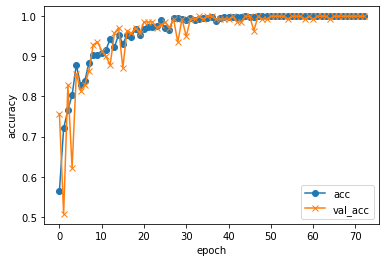

In [11]:
#汎化制度の評価・表示
score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# print(history.history)
#acc, val_accのプロット
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

In [ ]:
#モデルを保存
model.save("MyModel0617.h5")